# Configuration

### Define parameters of how you want to run your training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset can be "RUGD", "Rellis", or "Combined"
DATASET_NAME = "Combined"

# Panoptic Model can be "FPN_50_1x", "FPN_50_3x", or "FPN_101_3x"
PANOPTIC_MODEL = "FPN_50_3x"

# Iterations to run panoptic model training
TRAINING_ITERATIONS = 8000

In [ ]:
download_links = {
    "RUGD":     "1cuDAXrwG9NY4d4qsBy8h3OkzTmo2u3WE",
    "Rellis":   "1QVag_I9iAmpvCa-9EHYxnQsDKLJo0Y1D",
    "Combined": "1nBapUf3t4N71YOFXHKmLpAGoyfmITJqc"
}
detectron_panoptic_models = {
    "FPN_50_1x":  "COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml",
    "FPN_50_3x":  "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml",
    "FPN_101_3x": "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml" 
}

gdrive_link = download_links[DATASET_NAME]
detectron_zoo_model = detectron_panoptic_models[PANOPTIC_MODEL]
configuration_name = f"{DATASET_NAME}-{PANOPTIC_MODEL}"
print(configuration_name)

Combined-FPN_50_3x


# Setup

## Install necessary libraries and Detectron2
(If this is your first time running this notebook, you will likely need to restart the runtime after installing the libraries)

In [ ]:
# Install pyyaml
!pip install pyyaml==5.1
# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# Install Panoptic API from COCO
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 5.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ec85af4d33e41a515fbff04bebd435080f8e1eaf5d844998dc93787a1f28d4bb
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-umfl_jia
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-umfl_jia
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 79 kB 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-ab1y19_r
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-ab1y19_r
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=607d4d12eedcfb7595c0a92d3d464436a54238572572dcb1a02387d782850b2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_sv1j8o/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


## Import libraries

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
from google.colab.patches import cv2_imshow
from typing import List, Optional
import numpy as np
import cv2
import json
import os
import random
import ssl

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_panoptic_separated
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.panoptic_evaluation import COCOPanopticEvaluator
from detectron2.utils.visualizer import Visualizer


print(f"detectron2: {detectron2.__version__}")

detectron2: 0.6


In [ ]:
dataset_path = "datasets"

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

# Datasets

## Download the preprocessed dataset

In [ ]:
!gdown $gdrive_link

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1nBapUf3t4N71YOFXHKmLpAGoyfmITJqc 



## Extract the dataset

In [ ]:
extracted_path = os.path.join(dataset_path, DATASET_NAME)
print(extracted_path)

datasets/Combined


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/MastersProject/ColabNotebooks/PreprocessedDatasets/Combined.zip" -d $extracted_path

Streaming output truncated to the last 5000 lines.
  inflating: datasets/Combined/labels/train_semantic/park-1_01821.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01826.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01831.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01836.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01841.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01846.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01851.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01856.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01861.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01866.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01871.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01881.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01886.png  
  inflating: 

In [ ]:
zipped_file = f"{DATASET_NAME}.zip"
extracted_path = os.path.join(dataset_path, DATASET_NAME)
print(extracted_path)

!unzip $zipped_file -d $extracted_path

datasets/Combined
unzip:  cannot find or open Combined.zip, Combined.zip.zip or Combined.zip.ZIP.


# Panoptic Quality Evaluation

## Register Datasets

In [ ]:
def register_panoptic_datasets(dataset_name: str, dataset_dir: str):
    registered_names = []
    for group in ["train", "test"]:
        registered_name = f"{dataset_name}_{group}_separated"
        register_coco_panoptic_separated(
            name=f"{dataset_name}_{group}",
            metadata={},
            image_root=os.path.join(dataset_dir, "images", group),
            panoptic_root=os.path.join(dataset_dir, "labels", f"{group}_panoptic"),
            panoptic_json=os.path.join(dataset_dir, "labels", f"annotations_{group}_panoptic.json"),
            sem_seg_root=os.path.join(dataset_dir, "labels", f"{group}_semantic"),
            instances_json=os.path.join(dataset_dir, "labels", f"annotations_{group}_instances.json"),
        )

        registered_names.append(registered_name)
    return registered_names


registered_datasets = register_panoptic_datasets(DATASET_NAME, extracted_path)
print(registered_datasets)

['Combined_train_separated', 'Combined_test_separated']


## Update Metadata

In [ ]:
def update_metadata(panoptic_dataset_name: str, data_name: str):
    with open(f"datasets/{data_name}/labels/categories.json") as category_json:
        categories = json.load(category_json)

    thing_classes = [cat["name"] for cat in categories if cat["isthing"] == 1]
    stuff_classes = [cat["name"] for cat in categories if cat["isthing"] == 0]

    thing_ids = [cat["id"] for cat in categories if cat["isthing"] == 1]
    stuff_ids = [cat["id"] for cat in categories if cat["isthing"] == 0]
    thing_dataset_id_to_contiguous_id = {id: index for index, id in enumerate(thing_ids)}
    stuff_dataset_id_to_contiguous_id = {id: index for index, id in enumerate(stuff_ids)}

    metadata = MetadataCatalog.get(panoptic_dataset_name).set(
        thing_classes=thing_classes,
        stuff_classes=stuff_classes,
        thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
        stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
    )
    print(metadata)


for data_name in registered_datasets:
    update_metadata(data_name, DATASET_NAME)

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='datasets/Combined/images/train', json_file='datasets/Combined/labels/annotations_train_instances.json', name='Combined_train_separated', panoptic_json='datasets/Combined/labels/annotations_train_panoptic.json', panoptic_root='datasets/Combined/labels/train_panoptic', sem_seg_root='datasets/Combined/labels/train_semantic', stuff_classes=['void', 'dirt', 'sand', 'grass', 'tree', 'water', 'sky', 'generic-object', 'asphalt', 'gravel', 'building', 'mulch', 'rock-bed', 'fence', 'bush', 'sign', 'rock', 'bridge', 'concrete', 'barrier', 'mud'], stuff_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20}, thing_classes=['rubble', 'puddle', 'picnic-table', 'log', 'bicycle', 'person', 'vehicle', 'pole'], thing_dataset_id_to_contiguous_id={21: 0, 22: 1, 23: 2, 24: 3, 25: 4, 26: 5, 27: 6, 28: 7})
Metadata

## Setup Training Config

In [ ]:
def get_config(
    registered_names: List[str],
    config_name: str,
    zoo_model: str,
    checkpoint: Optional[str] = None,
    offset: int = 0,
    iter_count: int = 3000
):
    cfg = get_cfg()
    cfg.OUTPUT_DIR = os.path.join(cfg.OUTPUT_DIR, config_name)
    # cfg.MODEL.DEVICE = "cpu"  # Use CPU for debugging

    cfg.merge_from_file(model_zoo.get_config_file(zoo_model))
    cfg.DATASETS.TRAIN = (registered_names[0], )
    cfg.DATASETS.TEST = (registered_names[1], )
    cfg.DATALOADER.NUM_WORKERS = 2  # Number of processes to load data
    cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # Don't ignore images without instances

    if checkpoint:
        cfg.MODEL.WEIGHTS = checkpoint
    else:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(zoo_model) # Load in weights from model
    cfg.SOLVER.IMS_PER_BATCH = 6  # Batch size, number of images trained at the same time
    cfg.SOLVER.BASE_LR = 1e-3  # Learning rate
    cfg.SOLVER.MAX_ITER = offset + iter_count  # 3000 ~ 1 hr

    """ When generating semantic images using panopticapi, use the --things_other argument.
        It tells the converter script to set all things to 183 because they are ignored in semantic
        training and evaluation and we tell the model here to ignore pixels with value 183
    """
    cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE = 183  # Ignore things classes in semantic head
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # 8 thing classes
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 21  # 21 stuff classes

    cfg.MODEL.PANOPTIC_FPN.COMBINE.OVERLAP_THRESH = 0.5  # (default: 0.5)
    cfg.MODEL.PANOPTIC_FPN.COMBINE.STUFF_AREA_LIMIT = 4096  # (default: 4096)
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5  # (default: 0.5)
    cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.50]  # (default: 0.5)

    return cfg

## Train Panoptic Segmentation model

In [ ]:
model_cfg = get_config(
    registered_datasets,
    configuration_name,
    detectron_zoo_model,
    iter_count=TRAINING_ITERATIONS
)

os.makedirs(model_cfg.OUTPUT_DIR, exist_ok=True)
model_trainer = DefaultTrainer(model_cfg)
model_trainer.resume_or_load(resume=False)
model_trainer.train()

[07/28 14:46:00 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

model_final_c10459.pkl: 184MB [00:04, 41.7MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
sem_seg_head.predictor.{bias, weight}


[07/28 14:46:16 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/28 14:47:03 d2.utils.events]:  eta: 4:25:33  iter: 19  total_loss: 6.919  loss_sem_seg: 2.69  loss_rpn_cls: 0.4905  loss_rpn_loc: 0.1813  loss_cls: 2.351  loss_box_reg: 0.2039  loss_mask: 0.692  time: 1.9584  data_time: 0.2083  lr: 1.9981e-05  max_mem: 10576M
[07/28 14:47:43 d2.utils.events]:  eta: 4:29:04  iter: 39  total_loss: 4.942  loss_sem_seg: 1.666  loss_rpn_cls: 0.4046  loss_rpn_loc: 0.1474  loss_cls: 1.603  loss_box_reg: 0.2481  loss_mask: 0.688  time: 2.0007  data_time: 0.1972  lr: 3.9961e-05  max_mem: 10695M
[07/28 14:48:22 d2.utils.events]:  eta: 4:27:20  iter: 59  total_loss: 3.317  loss_sem_seg: 1.053  loss_rpn_cls: 0.2967  loss_rpn_loc: 0.1279  loss_cls: 0.6162  loss_box_reg: 0.2298  loss_mask: 0.6781  time: 1.9791  data_time: 0.1729  lr: 5.9941e-05  max_mem: 10695M
[07/28 14:49:02 d2.utils.events]:  eta: 4:26:29  iter: 79  total_loss: 2.358  loss_sem_seg: 0.785  loss_rpn_cls: 0.2481  loss_rpn_loc: 0.1316  loss_cls: 0.3458  loss_box_reg: 0.1637  loss_mask: 0.6727  ti

In [ ]:
# Save output folder
outputdir = model_cfg.OUTPUT_DIR
!cp -r "output" "/content/drive/MyDrive/Colab Notebooks"

## Evaluate Model

In [ ]:
def evaluate_model(cfg, trainer, data_name: str, test_group: str):
    evaluator = COCOPanopticEvaluator(test_group, output_dir=f"/eval_{data_name}")
    val_loader = build_detection_test_loader(cfg, test_group)
    eval_results = inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
evaluate_model(model_cfg, model_trainer, configuration_name, registered_datasets[1])

WARNING [06/30 06:52:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/30 06:52:14 d2.data.datasets.coco]: Loaded 2734 images in COCO format from datasets/Combined/labels/annotations_test_instances.json
WARNING [06/30 06:52:14 d2.data.datasets.coco]: Filtered out 818 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
[06/30 06:52:14 d2.data.datasets.coco]: Loaded 2734 images with semantic segmentation from datasets/Combined/images/test
[06/30 06:52:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/30 06:52:14 d2.data.common]: Serializing 2734 elements to byte tensors and concatenating them all ...
[06/30 06:52:14 d2.data.common]: Serialized dataset takes 3.63 MiB


## Display Prediction

In [ ]:
model_cfg.MODEL.WEIGHTS = os.path.join(model_cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(model_cfg)

[06/30 07:06:22 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

frame002177-1581797368_109.jpg


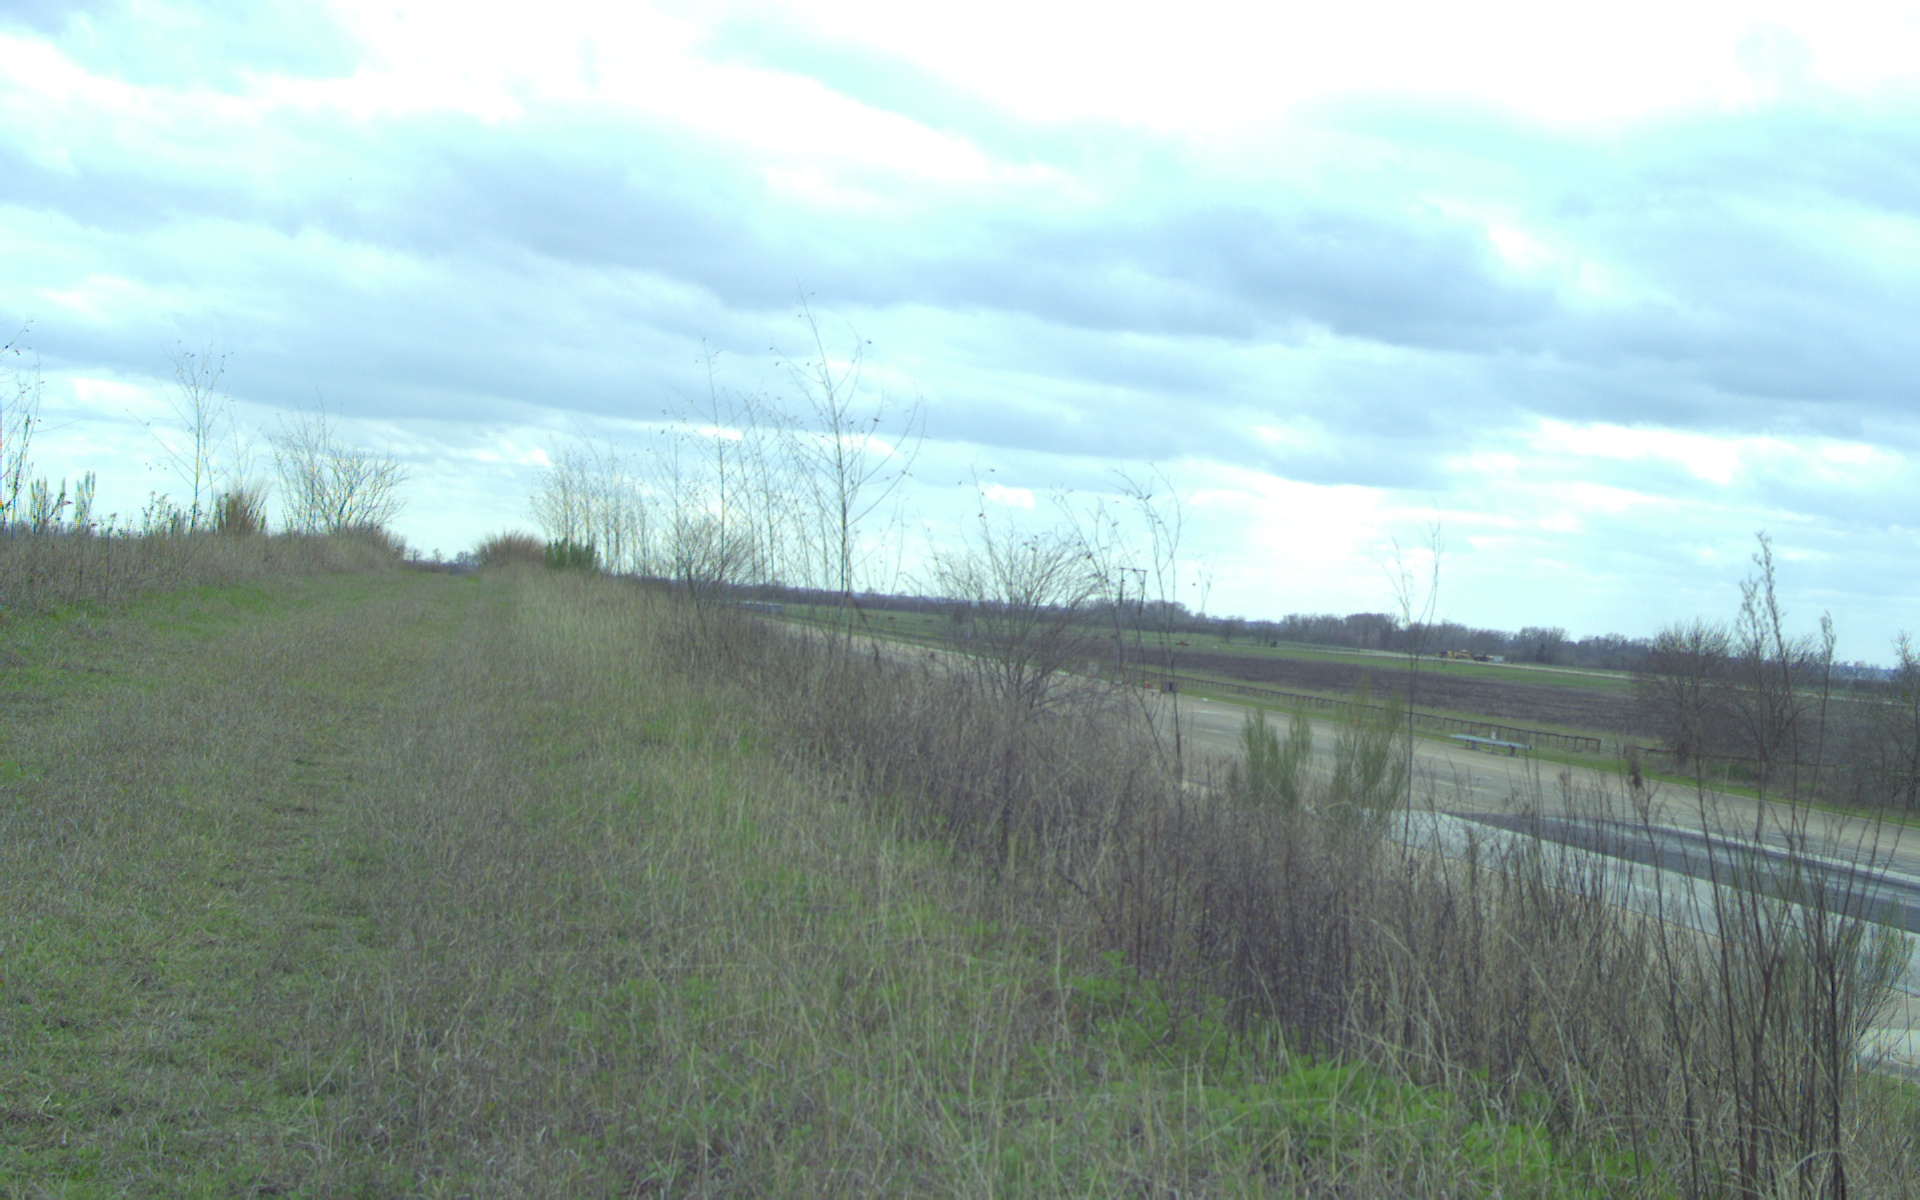

In [ ]:
test_image_dir = os.path.join(extracted_path, "images", "test")
test_image_filename = random.choice(os.listdir(test_image_dir))
print(test_image_filename)

im = cv2.imread(os.path.join(test_image_dir, test_image_filename))
cv2_imshow(im)

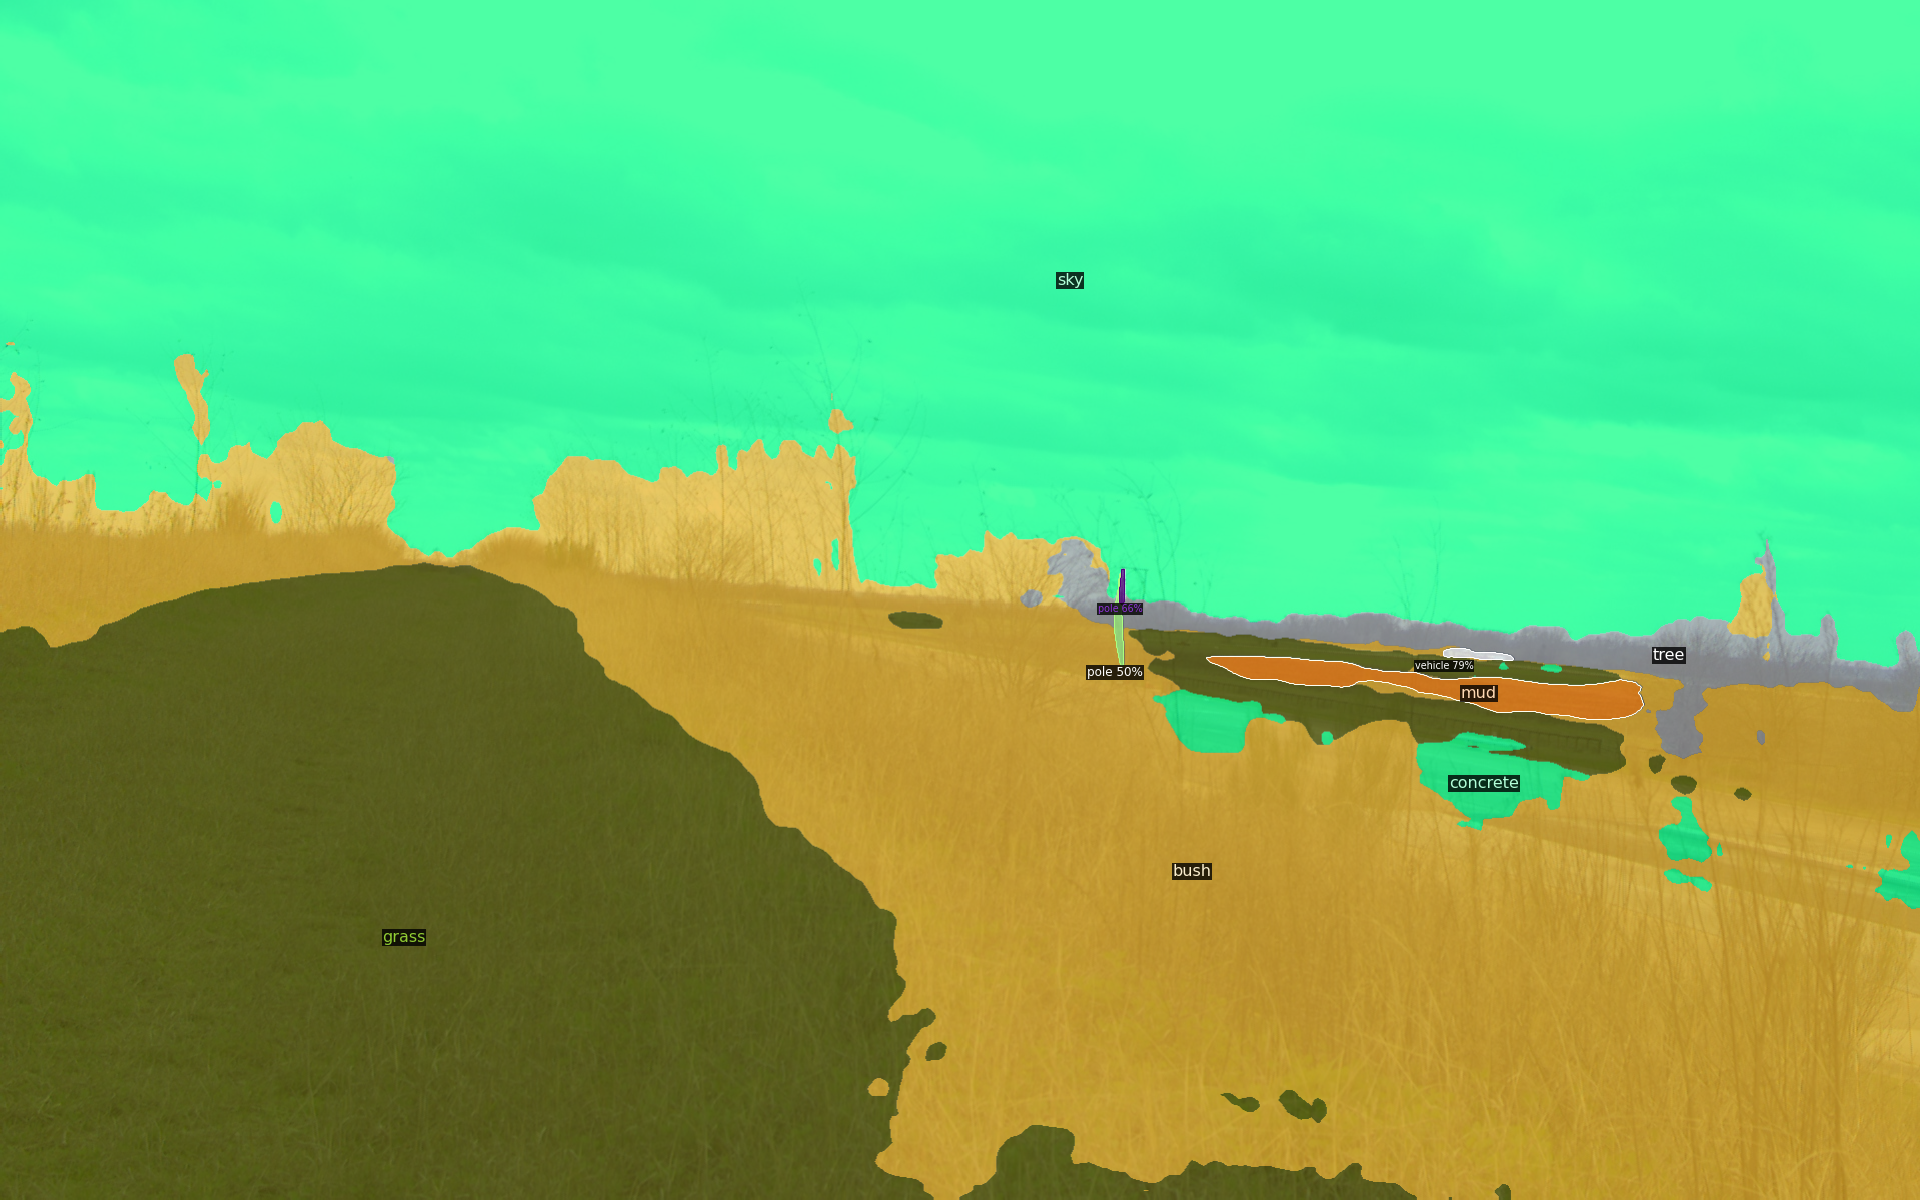

In [ ]:
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(model_cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])